In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
import os

In [33]:
def get_data(fili, variable, swap_latlon=True):
    
    ds = xr.open_dataset(fili)

    if swap_latlon: 
        ds.rename({'lat': 'lonx', 'lon': 'latx'}, inplace=True)
        ds.rename({'latx': 'lat', 'lonx': 'lon'}, inplace=True)
        
    da = ds[variable]
    da = da * 1e3 # Scale to mm
    
    # Get attributes
    da.attrs = ds[variable].attrs
    da.attrs['units'] = 'mm'

    proj = ccrs.PlateCarree()
    extent = [da.coords['lon'].values[0],
              da.coords['lon'].values[-1],
              da.coords['lat'].values[0],
              da.coords['lat'].values[-1]]
    origin = 'upper'
    
    return da, proj, extent, origin


In [28]:
def get_latlon():
    
    diri = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce'
    latfile = 'Na25.lat.361x361x1.float'
    lonfile = 'Na25.lon.361x361x1.float'
    
    lat = np.fromfile(os.path.join(diri,latfile), dtype=float32).reshape(361,361)
    lon = np.fromfile(os.path.join(diri,lonfile), dtype=float32).reshape(361,361)
    
    return lat, lon

In [34]:
diri = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce'
fili = 'era_interim.PRECTOT.201501.day.nc'

precip, pproj, pextent, porigin = get_data(os.path.join(diri,fili), 'PRECTOT')

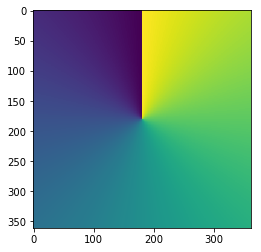

In [30]:
lat, lon = get_latlon()

plt.imshow(lon)

In [52]:
rlat = precip.coords['lat'].data
rlon = precip.coords['lon'].data
drlat = rlat[1] - rlat[0]
drlon = rlon[1] - rlon[0]
rlat0 = rlat[0]
rlon0 = rlon[0]
print drlat, drlon, rlat0, rlon0

-0.75 0.75 90.0 0.0


In [49]:
j = np.floor((lat.flatten - rlat0)/drlat)
i = np.floor((lon.flatten - rlon0)/drlon)

13.333333333333334

In [90]:
def regridll(ilat, ilon, olat, olon, test=False):
    '''
    ilat - scalar or array of input latitudes
    ilon - scalar or array of input latitudes
    olat - array of output latitude
    olon - array of output longitude
    '''
    
    dolat = olat[1] - olat[0]
    dolon = olon[1] - olon[0]
    olat0 = olat[0]
    olon0 = olon[0]

    j = np.floor((ilat.flatten() - olat0)/dolat).astype(int)
    i = np.floor((ilon.flatten() - olon0)/dolon).astype(int)
    
    if test:
        print 'Input -> Output'
        print 'ilat={:9.4f}, j={}, olat={:9.4f}'.format(ilat, j[0], olat[j])
        print 'ilon={:9.4f}, i={}, olon={:9.4f}'.format(ilon, i[0], olon[i])
        
    return i, j

In [107]:
i, j = regridll(lat[0,0], lon[0,0], precip.coords['lat'].data, precip.coords['lon'].data)

In [108]:
lon[0,0], lat[0,0], i[0], j[0], precip.coords['lon'].data[180], precip.coords['lat'].data[80]

(-135.0, 29.896942, -180, 80, 135.0, 30.0)

In [106]:
ilon = 225.
(np.abs(precip.coords['lon'].data -ilon)).argmin()

300

In [109]:
precip.coords['lon'].data[180]

135.0

In [131]:
alon = np.array([0., 45., 90., 135., 180., 225., 270., 315.])
alat = np.array([-90., -45., 0., 45., 90.])

In [133]:
def getij(ilon, ilat, olon, olat):
    
    # Make sure everything is a numpy array
    iilon = np.array(ilon)
    iilat = np.array(ilat)
    oolon = np.array(olon)
    oolat = np.array(olat)
    
    # Convert longitude arrays to span 0. to 360.
    iilon = np.where(iilon < 0., 360.+iilon, iilon)
    oolon = np.where(oolon < 0., 360.+oolon, oolon)
    
    i = np.abs(oolon - iilon).argmin()
    j = np.abs(oolat - iilat).argmin()
    
    return i, j

In [142]:
i, j = getij(1., 27., alon, alat)
print alon[i], alat[j]

0.0 45.0


In [145]:
print np.abs(alon - 355.)

[ 355.  310.  265.  220.  175.  130.   85.   40.]
